In [21]:
# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Additional Dependencies needed for our analysis
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect                   # Inspects the database schema.

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# Reflect an existing database into a new model
Base = automap_base() # Initializes the automap base class.

# Reflect the tables in the database
Base.prepare(engine, reflect=True)  # Reflects the database schem
Base.classes.keys() #Display the classes/tables


C:\Users\mssab\AppData\Local\Temp\ipykernel_16480\2864961818.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)  # Reflects the database schem


['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# A new variable was created as we need it in our future analysis
#Otherwise, I could use 'session.query(Measurement.date).order_by(DMeasurement.date.desc()).first()' option
most_recent_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

## Station data does not have a 'date' column


('2017-08-23',)


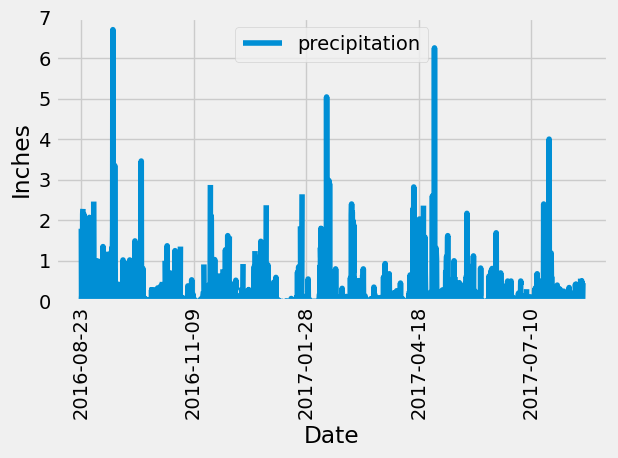

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set (366 days were deducted to match the assigment output, as a year prior would be 2016-8-24, 365 days)
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
date_one_year_ago = most_recent_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date >= date_one_year_ago)\
                            .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'precipitation'])

# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='precipitation', legend=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)  # Rotate date labels for better readability
plt.ylim(0, 7)  # Set y-axis range from 0 to 7
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
# Display summary statistics 
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
stations_number= session.query(func.count(Measurement.station.distinct())).all()
print(stations_number)

[(9,)]


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).all()

# Output the list of stations with their counts in descending order, each on a new line, to match assigment
# I used f function as such format makes it easier to undrstand the data
for station, count in most_active_stations:
    print(f"Station: {station}, Count Number: {count}")

Station: USC00519281, Count Number: 2772
Station: USC00519397, Count Number: 2724
Station: USC00513117, Count Number: 2709
Station: USC00519523, Count Number: 2669
Station: USC00516128, Count Number: 2612
Station: USC00514830, Count Number: 2202
Station: USC00511918, Count Number: 1979
Station: USC00517948, Count Number: 1372
Station: USC00518838, Count Number: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Setting a variable for the most active satation based on the output above
station_id = 'USC00519281'

# Finding the lowest, higherst, and average temperatures for selected station:
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    Measurement.station == station_id
).all()

# Show the results of the query above
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

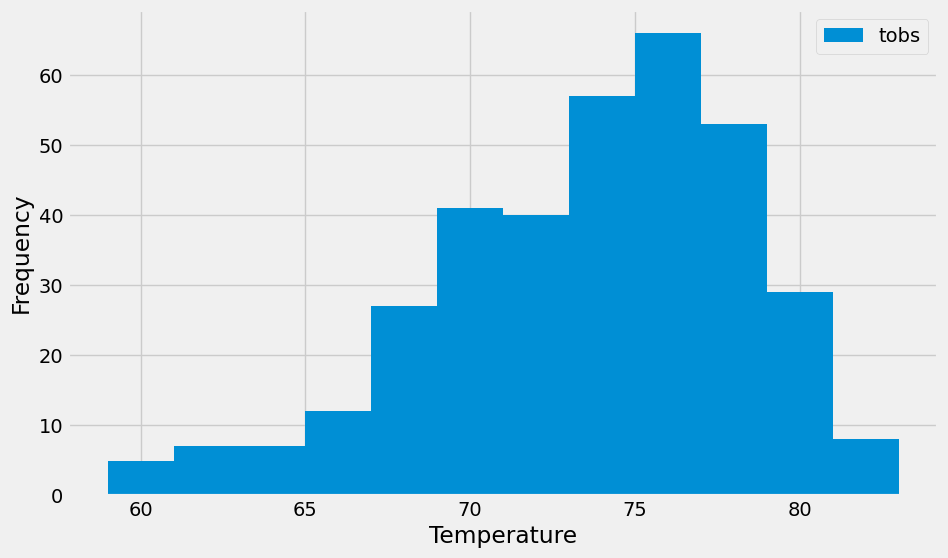

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Retrieve the temperature data for the past year for the most active station only
temperature_data = session.query(Measurement.tobs)\
                          .filter(Measurement.station == 'USC00519281')\
                          .filter(Measurement.date >= date_one_year_ago)\
                          .all()

# Preparing data for plotting (extracting first element from each tuple)
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [20]:
# Close Session
session.close()